### Final Model IT2Tsk Gaussian

In [1]:

from notebook_resolver import *
from src.utils.pandas_extension import *
from src.dataset import Dataset, WorkSheet

dataset_path = "data/e-nose_dataset_12_beef_cuts.xlsx"
worksheet = WorkSheet.DS8.value

dataset = Dataset(
	path=dataset_path, sheet_name=worksheet,
)

train_df = dataset.train_df
test_df = dataset.test_df # <-- Test data only for final evaluation

In [2]:
from sklearn.metrics import r2_score
from src.pipeline import Pipeline
from src.pipelines.transformers import FeatureScaler
from src.pipelines.predictors import IT2TskPredictor
from src.fis.fuzzy_logic.mfs import MFType2
from src.clusters import ClusteringMethod
from src.fis.fuzzy_logic.consequents import LinearModel
from src.utils.hyperparameter import get_tuned_params

target_column = 'TVC'
# tuned_params = get_tuned_params()[worksheet]
tuned_params = {
	"batch_size": 256,
	"tol": 0.001,
	"max_no_improvement": 5,
	"uncertainty_factor": 0.07,
	"min_std_ratio": 0.06,
}

pipeline = Pipeline(steps=[
	('feature_scaler', FeatureScaler(decimal_places=4)),
	('predictor', IT2TskPredictor(target=target_column))
])

pipeline.fit(
    train_df, # pipeline fit only for training dataframe
    predictor__clustering_method=ClusteringMethod.MBKMEANS,
	predictor__mfs__cluster__batch_size=tuned_params.get("batch_size"),
	predictor__mfs__cluster__tol=tuned_params.get("tol"),
	predictor__mfs__cluster__max_no_improvement=tuned_params.get(
		"max_no_improvement"
	),  # Fixed for simplicity
	predictor__rules__cluster__batch_size=tuned_params.get("batch_size"),
	predictor__rules__cluster__tol=tuned_params.get("tol"),
	predictor__rules__cluster__max_no_improvement=tuned_params.get(
		"max_no_improvement"
	),  # Fixed for simplicity
	predictor__mf_type=MFType2.GAUSSIAN,
	predictor__linear_model=LinearModel.LSE,
	predictor__mf__builder__uncertainty_factor=tuned_params.get(
		"uncertainty_factor"
	),
	predictor__mf__builder__min_std_ratio=tuned_params.get(
		"min_std_ratio"
	),	
)

transformed_test_df = pipeline.transform(test_df)
X_test_df = transformed_test_df.drop(columns=[target_column])

y_test_ = transformed_test_df[target_column].values
y_pred_ = pipeline.predict(X_test_df)

r2 = r2_score(y_test_, y_pred_)
print(f"R2 Score on Test Data: {r2}")

R2 Score on Test Data: 0.9943730956547251


In [3]:
tuned_params

{'batch_size': 256,
 'tol': 0.001,
 'max_no_improvement': 5,
 'uncertainty_factor': 0.07,
 'min_std_ratio': 0.06}

In [4]:
predictor = pipeline.named_steps['predictor']

In [5]:
predictor.get_lt_rules()

+--------+-----------+------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Rule   | Cluster   | IF (Antecedents)                         | THEN (Consequents)                                                                                                                                                           |
+========+===========+==========================================+==============================================================================================================================================================================+
| Rule 1 | Cluster 0 | MQ135 is Low AND MQ136 is Low AND MQ137  | TVC is 0.8569 + 0.0013*MQ135 + 0.0232*MQ136 + 0.1503*MQ137 + -0.221*MQ138 + 0.0006*MQ2 + -0.1434*MQ3 + 0.9423*MQ4 + 0.0176*MQ5 + -0.02*MQ6 + 0.0031*MQ8 + -0.0056*MQ9        |
|        |           | is High AND M

,Rule,Cluster,IF (Antecedents),THEN (Consequents)
0,Rule 1,Cluster 0,MQ135 is Low AND MQ136 is Low AND MQ137 is Hig...,TVC is 0.8569 + 0.0013*MQ135 + 0.0232*MQ136 + ...
1,Rule 2,Cluster 1,MQ135 is High AND MQ136 is High AND MQ137 is L...,TVC is 0.9396 + -0.2521*MQ135 + -0.5253*MQ136 ...
2,Rule 3,Cluster 2,MQ135 is High AND MQ136 is Low AND MQ137 is Lo...,TVC is 0.7649 + -0.0318*MQ135 + -0.3792*MQ136 ...


In [6]:
predictor.clusters_.get_execution_time_stats('_create_mfs_clusters')

{'count': 1,
 'total_time': 3.1333769590128213,
 'average_time': 3.1333769590128213,
 'min_time': 3.1333769590128213,
 'max_time': 3.1333769590128213}

In [7]:
predictor.clusters_.get_execution_time_stats('_create_rules_cluster')

{'count': 1,
 'total_time': 0.46006374998250976,
 'average_time': 0.46006374998250976,
 'min_time': 0.46006374998250976,
 'max_time': 0.46006374998250976}

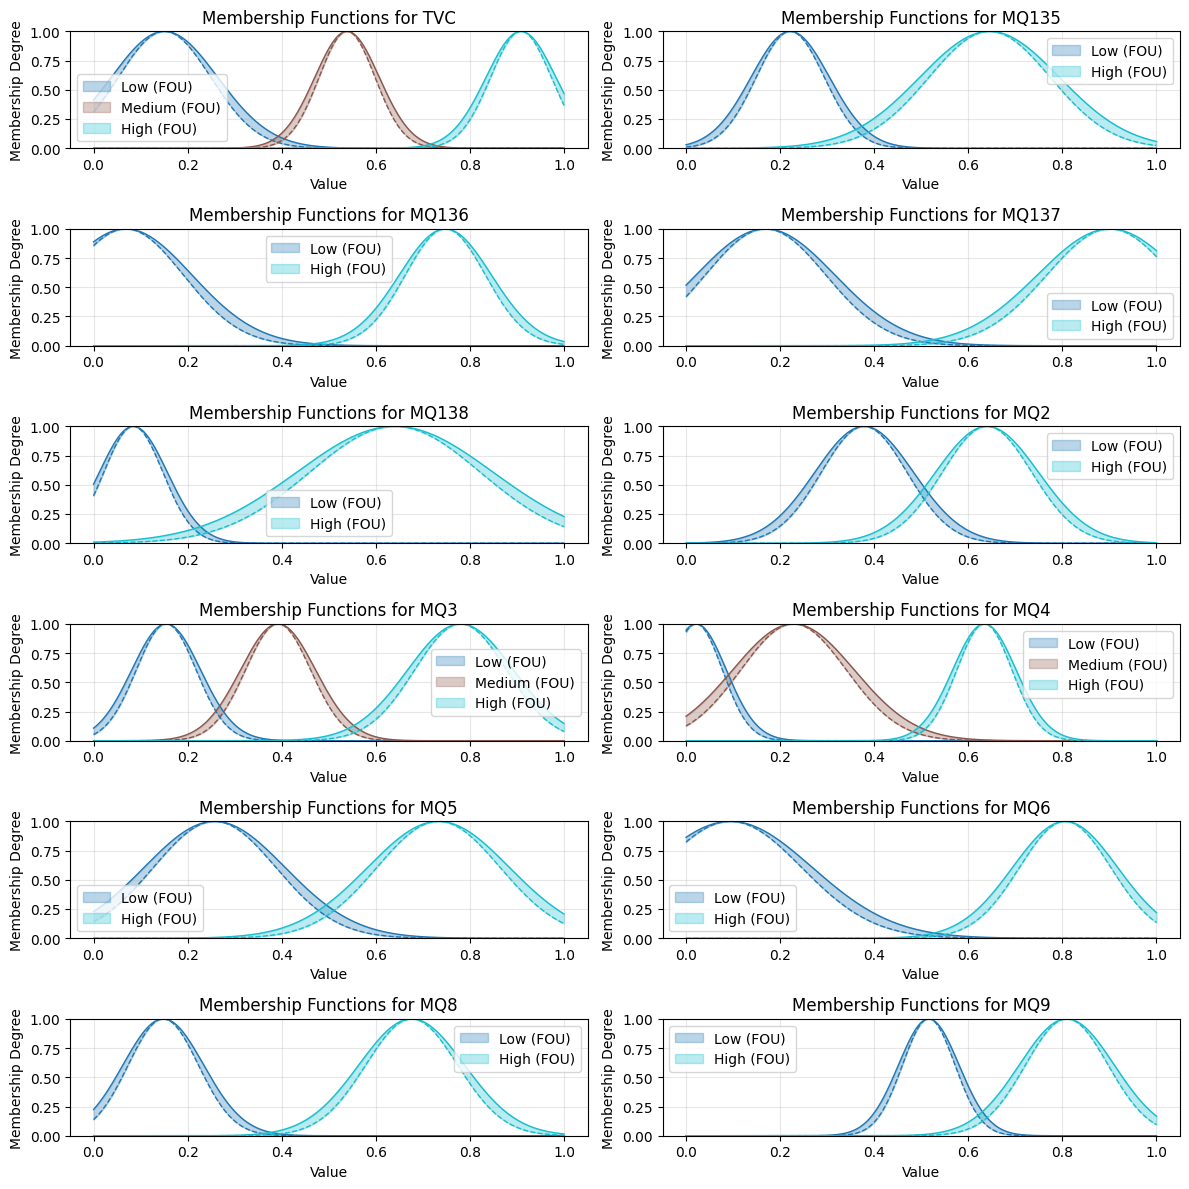

In [8]:
predictor.plot_mfs_grid()

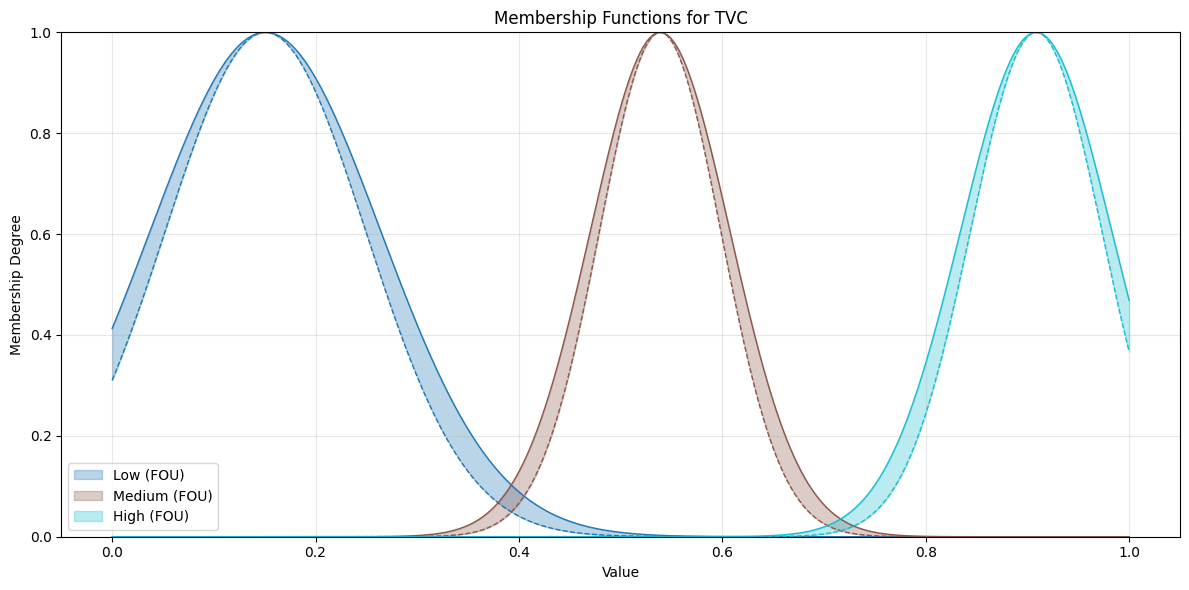

In [9]:
predictor.plot_mf('TVC')

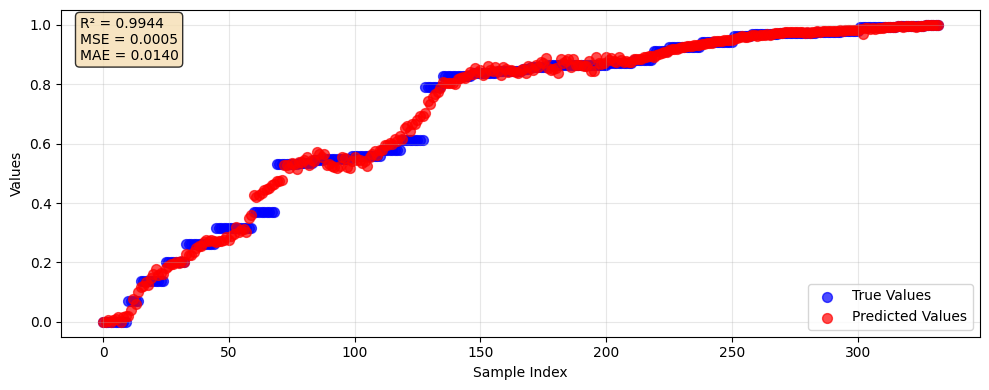

In [10]:
predictor.plot_true_vs_pred(y_true=y_test_, y_pred=y_pred_, title="")